In [1]:
import pickle
import math
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_table('./ml-100k/u1.base', sep='\t', header = None, names=['user_id','item_id','rating','timestamp'])
data_test = pd.read_table('./ml-100k/u1.test', sep='\t', header = None, names=['user_id','item_id','rating','timestamp'])
N = 943
M = 1682
k = 15
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
user_id      80000 non-null int64
item_id      80000 non-null int64
rating       80000 non-null int64
timestamp    80000 non-null int64
dtypes: int64(4)
memory usage: 2.4 MB


In [3]:
R = np.zeros([N, M])
R_test = np.zeros([N, M])
# 用户因子矩阵P， 物品因子矩阵Q初始化
P = np.random.random((N, k))
Q = np.random.random((M, k))
# 填充原始评分矩阵
for _, line in data.iterrows():
    R[line['user_id']-1][line['item_id']-1] = int(line['rating'])
for _, line in data_test.iterrows():
    R_test[line['user_id']-1][line['item_id']-1] = int(line['rating'])

In [4]:
def calc_loss(P, Q, R):
    '''
        计算loss， P为用户评分矩阵， Q为物品因子矩阵， R为原始矩阵
        P, Q, R 都是np.matrix
    '''
    R_pre = P.dot(Q.T)
    diff = R - R_pre
    e_sum = 0
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if R[i][j] > 0:
                e_sum += diff[i][j]**2
    return e_sum

def calc_loss_matrix(P, Q, R):
    return R - P.dot(Q.T)

def alternating_least_square(P, Q, R, R_test, learning_rate = 0.002, turns=50, silence=True, plot=True):
    '''
        交替最小二乘
    '''
    loss_matrix = R - P.dot(Q.T)
    train_loss_list = []
    validation_loss_list = []
    # 固定物品因子矩阵
    for step in range(turns):
        for i in range(P.shape[0]):
            for j in range(Q.shape[0]):
                if R[i][j] > 0:
                    eij = float(R[i][j] - np.dot(P[i, :], Q[j, :].T))
                    for k in range(P.shape[1]):
                        P[i][k] = P[i][k] + 2*learning_rate*eij*Q[j][k]
                        Q[j][k] = Q[j][k] + 2*learning_rate*eij*P[i][k]
        train_loss = calc_loss(P, Q, R)
        validation_loss = calc_loss(P, Q, R_test)
        train_loss_list.append(train_loss)
        validation_loss_list.append(validation_loss)
        if silence == False:
            print("Turns", step, " train loss is", train_loss, " test loss is", validation_loss)
        if validation_loss < 0.001:
            break
    if plot == True:
        plt.plot(range(len(train_loss_list)), train_loss_list)
        plt.plot(range(len(validation_loss_list)), validation_loss_list)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Alternating Least Square')
        plt.legend(['train', 'validation'])
        plt.show()
    return P, Q

Turns 0  train loss is 85496.6242637  test loss is 24014.4757976
Turns 1  train loss is 73147.6652743  test loss is 21380.6890835
Turns 2  train loss is 69224.9236782  test loss is 20767.5280798
Turns 3  train loss is 66673.0214631  test loss is 20535.3190549
Turns 4  train loss is 64588.7735577  test loss is 20452.2226044
Turns 5  train loss is 62670.8208447  test loss is 20443.818174
Turns 6  train loss is 60805.4358206  test loss is 20478.5709515
Turns 7  train loss is 58964.302964  test loss is 20541.4619326
Turns 8  train loss is 57162.1270181  test loss is 20625.5937711
Turns 9  train loss is 55427.8373396  test loss is 20728.0597845
Turns 10  train loss is 53785.9595723  test loss is 20847.0734586
Turns 11  train loss is 52250.1097478  test loss is 20980.3811326
Turns 12  train loss is 50824.3848566  test loss is 21124.9838685
Turns 13  train loss is 49506.8292935  test loss is 21277.5644602
Turns 14  train loss is 48292.2128375  test loss is 21434.9978624
Turns 15  train loss i

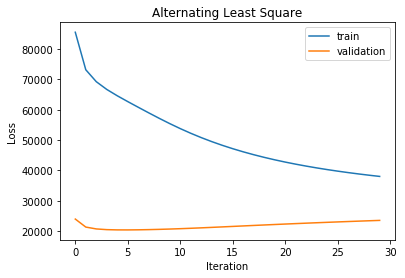

In [5]:
nP, nQ = alternating_least_square(P, Q, R, R_test, learning_rate=0.005, turns=30, silence=False)
nR = nP.dot(nQ.T)